In [1]:
# reproducable randomness
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

c:\users\ck\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

#### PyPi Modules

In [3]:
import tensorflow as tf
import numpy as np
from keras import backend as K

Using TensorFlow backend.


#### Local Modules

In [74]:
from neural_stylization.vgg19 import VGG_19
from neural_stylization._img_util import load_image, image_to_matrix, normalize, denormalize, matrix_to_image
from neural_stylization.jupyter_plot import JupyterPlot
from keras import backend as K

# Loading Image

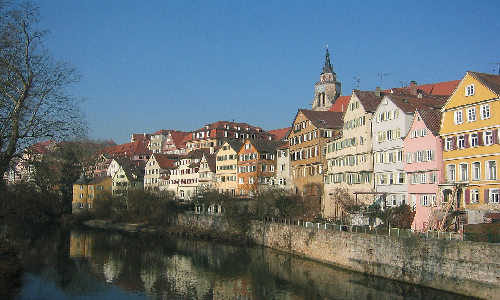

In [5]:
tubingen = load_image('img/content/tubingen.jpg', (500, 300))
tubingen

## Binary Image $\to$ 4D Tensor 

To process the image by the VGG model, we need it in a 4 dimensional
tensor of the shape schema $[frame, height, width, channel]$.

*   $frame$ indexes one of several frames passing through the network
*   $channel$ indexes the _color channel_.
    *   RGB $\implies$ 3
    *   Black and White $\implies$ 1

In [6]:
# convert the binary image data to a Numpy matrix
img = image_to_matrix(tubingen)
img.shape

(1, 300, 500, 3)

In [7]:
# calculate the mean value for each channel
means = img[0].mean(axis=0).mean(axis=0)
means

array([103.283264, 115.21149 , 120.40684 ], dtype=float32)

In [8]:
# normalize the image by the means in the ImageNet data
img = normalize(img)
norm_means = img[0].mean(axis=0).mean(axis=0)
norm_means

array([ 16.467709 ,  -1.5675138, -20.396757 ], dtype=float32)

In [9]:
# invert the means from RGB to BGR using the [::-1] 
# then subtract from the normalized means. This should
# produce the ImageNet means: [103.939, 116.779, 123.68]
means[::-1] - norm_means

array([103.93913, 116.779  , 123.68002], dtype=float32)

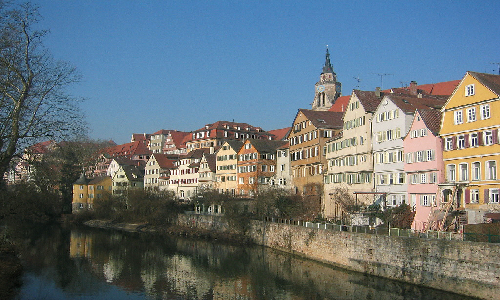

In [10]:
# validate the work by converting back to the Original
# image with no changes made
matrix_to_image(denormalize(img[0]))

In [ ]:
def content_loss(content, combination):
    """
    Return the content loss between the content and combinations tensors.

    Args:
        content: the original content tensor to measure loss from
        combination: the combination image to reduce the loss of

    Returns: the scalar loss between `content` and `combination`
    """
    # squared euclidean distance, exactly how it is in the paper
    return 0.5 * K.sum(K.square(combination - content))

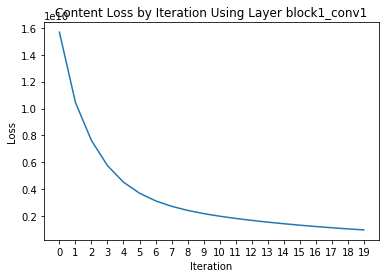

In [89]:
# load the content image into keras as a constant, it never changes
content = K.constant(img, name='Content')
# create a placeholder for the trained image, this variable trains
canvas = K.placeholder(img.shape, name='Cavnas')
# combine the content and canvas tensors along the frame axis (0) 
# into a 4D tensor of shape [2, height, width, channels]
tensor = K.concatenate([content, canvas], axis=0)
# build the model with the 4D input tensor of content and canvas
model = VGG_19(include_top=False, input_tensor=tensor)

layer_name = 'block1_conv1'
# extract the layer's out that we have interest in for reconstruction
layer = model.get_layer(layer_name).output

# calculate the loss between the output of the layer on the 
# content (0) and the canvas (1) 
loss = content_loss(layer[0], layer[1])

# calculate the gradients of the model inputs with respect to 
# the loss. i.e. backpropagate the loss through the network 
# to the input layer
grads = K.gradients(loss, model.input)[0]

# generate the iteration function for gradient descent optimization
# Args:
#     noise: the input to the noise placeholder in the model
#         this effectively takes a the white noise image being
#         optimized and passes it forward and backward through 
#         the model collecting the loss and gradient along the 
#         way
# 
# Returns:
#     a tuple of (loss, gradients)
#     -   loss: the content loss between the content image
#         and the white noise
iterate = K.function([canvas], [loss, grads])

# generate random noise
noise = normalize(np.random.normal(128, 64, (1, 300, 500, 3)))
# create a new interactive plot to visualize the loss in realtime
plot = JupyterPlot(title=f'Content Loss by Iteration Using Layer {layer_name}', xlabel='Iteration', ylabel='Loss')
# perform the specified iterations of gradient descent
for i in range(20):
    # pass the noise the canvas tensor generating the loss
    # and gradients as a tuple
    loss_i, grads_i = iterate([noise])
    # move the noise based on the gradients and learning rate
    noise[0, :, :, :] -= grads_i[1] * 1e-2
    # update the plot with the loss for this iteration
    plot(loss_i)
    
K.clear_session()

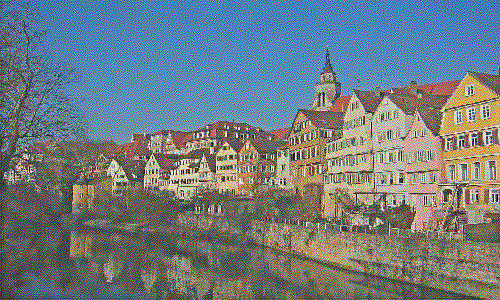

In [88]:
# denormalize the image to add the mean values
# of the network back and flip the channels back
# to RGB from BGR. convert this RGB matrix to 
# an image we can look at
matrix_to_image(denormalize(noise[0]))